In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Check GPAW DFT calculations

Bridge Bandgap = 0.73197 eV
Device Bandgap = 0.013050000000000672 eV


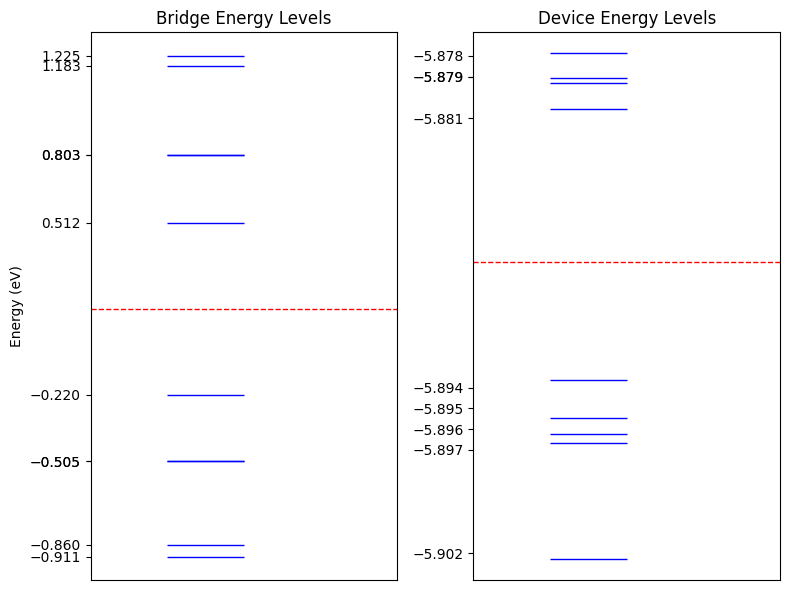

In [ ]:
# --- Bridge data obtained manually from gpaw's .txt output ---
E_fermi_bridge = 0.14644041935951402
bridge_levels = np.array([-0.91088, -0.85980, -0.50541, -0.50540, -0.21988,
                          0.51209, 0.80314, 0.80315, 1.18291, 1.22505])

# --- Device data obtained manually from gpaw's .txt output ---
E_fermi_device = -5.88795319605644
device_levels = np.array([-5.90228, -5.89667, -5.89622, -5.89546, -5.89362,
                          -5.88057, -5.87930, -5.87908, -5.87786])

# --- Bandgap calculation function ---
def compute_bandgap(levels, E_fermi, tol=1e-6):
    occ = levels[levels <= E_fermi + tol]
    unocc = levels[levels > E_fermi - tol]
    homo = occ.max() if occ.size else None
    lumo = unocc.min() if unocc.size else None
    if homo is not None and lumo is not None and lumo > homo:
        return lumo - homo, homo, lumo
    else:
        return 0.0, homo, lumo

# Calculate bandgaps
bridge_gap, bridge_homo, bridge_lumo = compute_bandgap(bridge_levels, E_fermi_bridge)
device_gap, device_homo, device_lumo = compute_bandgap(device_levels, E_fermi_device)

print(f"Bridge Bandgap = {bridge_gap} eV")
print(f"Device Bandgap = {device_gap} eV")

# --- Plotting side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharex=False, sharey=False)

# Bridge plot
x_start_line, x_end_line = 0.25, 0.5
axes[0].set_title("Bridge Energy Levels")
for energy in bridge_levels:
    axes[0].hlines(y=energy, xmin=x_start_line, xmax=x_end_line, colors='b', linewidth=1)
axes[0].hlines(y=E_fermi_bridge, xmin=0, xmax=1, colors='red', linestyle='--', linewidth=1)
axes[0].set_ylabel("Energy (eV)")
axes[0].set_ylim(min(bridge_levels) - 0.1, max(bridge_levels) + 0.1)
axes[0].set_xlim(0, 1)
axes[0].set_yticks(np.round(bridge_levels, 3))
axes[0].set_xticks([])

# Device plot
axes[1].set_title("Device Energy Levels")
for energy in device_levels:
    axes[1].hlines(y=energy, xmin=x_start_line, xmax=x_end_line, colors='b', linewidth=1)
axes[1].hlines(y=E_fermi_device, xmin=0, xmax=1, colors='red', linestyle='--', linewidth=1)
axes[1].set_ylim(min(device_levels) - 1e-3, max(device_levels) + 1e-3)
axes[1].set_xlim(0, 1)
axes[1].set_yticks(np.round(device_levels, 3))
axes[1].set_xticks([])

plt.tight_layout()
plt.show()


#### Comparison to literature

Source 1 : "Contacting individual graphene nanoribbons using carbon nanotube electrodes, Jian Zhang et al"

For 9-AGNR, they provide the following bandstructure and DOS. The bandgap is ~796 meV:

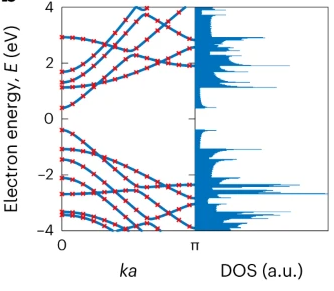

Source 2 : "Energy gaps in graphene nanoribbons, YW Son, S.G. Louie"

Extracting data from the plot below using webplotdigitizer, the bandgap for 9-AGNR is ~732 meV:

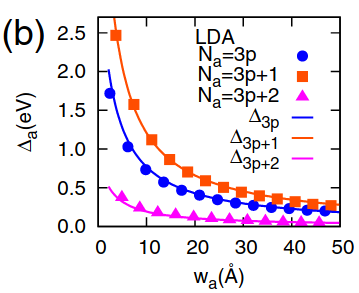

Comparing our own value, ~732 meV, I conclude that our bandgap for 9-AGNR is within acceptable range

### Check Local orbitals

The lowdin orthogonalized orbitals are:

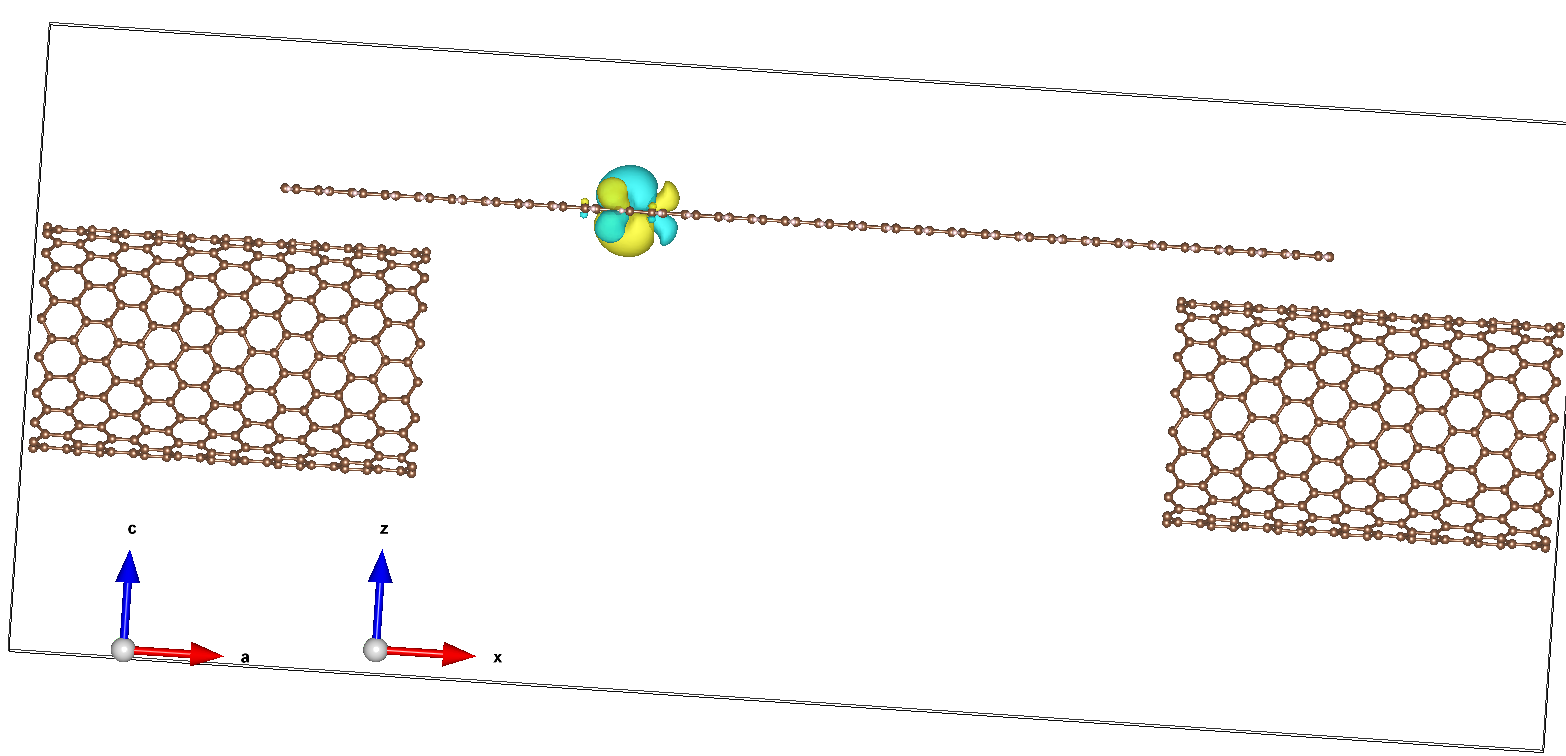

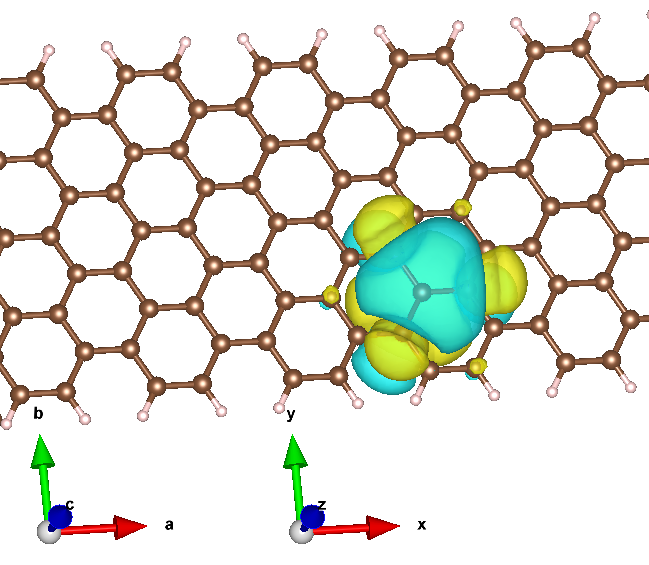

The non-orthogonalized orbital is:

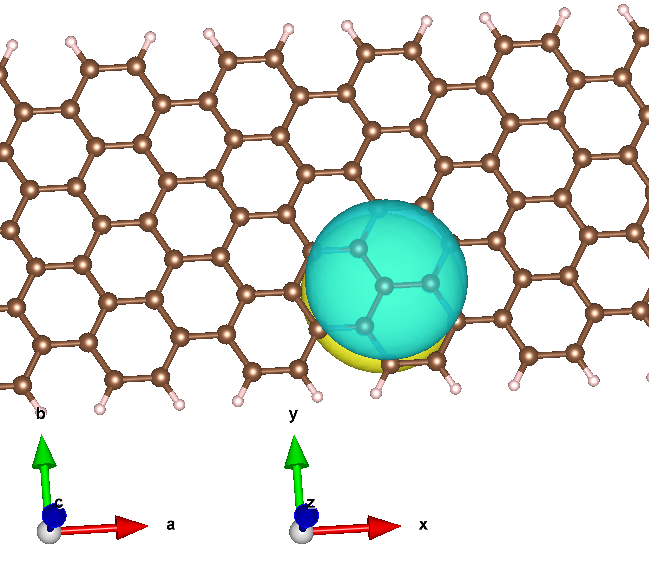

### Check DOS of device projected on bridge

In the output below, the total DOS is obtained by projecting the total Green's function onto the molecule. From the code perspective, this means that the total DOS needs to use `ProjectedGreenFunction` with indices that include all orbitals in the bridge and not just the C 2 pz.

/tmp/ipykernel_1555532/3396390550.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10)


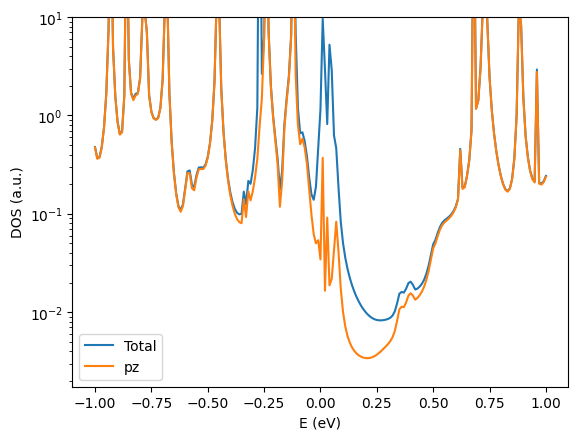

In [11]:
E, tdos_device = np.load("./unrelaxed/output/lowdin/device/dft/Evdos_total.npy")
_, pz_dos_device = np.load("./unrelaxed/output/lowdin/device/dft/Evdos_pz.npy")

plt.plot(E, tdos_device, label="Total")
plt.plot(E, pz_dos_device, label="pz")
plt.xlabel("E (eV)")
plt.ylabel("DOS (a.u.)")
plt.yscale("log")
plt.ylim(0,10)
plt.legend()
plt.show()


I'm not sure if there are errors in the DOS computation, or if the hamiltonian is wrong. Either way, the DOS plot looks incorrect? One way to check if it's the script that is incorrect would be to use the same script to reproduce the plot in the "Smart Local Orbitals" paper on the 1,3-BDA molecular junction.

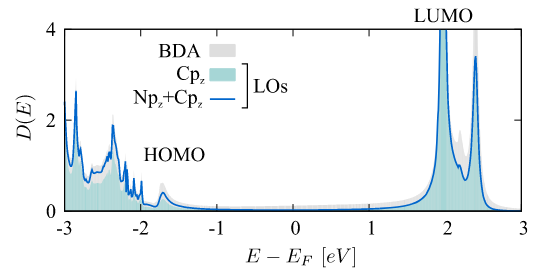

<del>The old calculations on this system seems to indicate that the DOS script was unable to reproduce the plot in the paper (as shown below). It isn't an issue of using `ProjectedGreenFunction` vs `GreenFunction` because neither of them produces the right plot. Yet the `GreenFunction` produces the right transmission function. </del>

<!-- ![alt text](image.png) -->

However, if there are no errors in the calculation, we have a state at Fermi energy that isn't described by C 2 pz alone. 

### Check DOS of bridge 

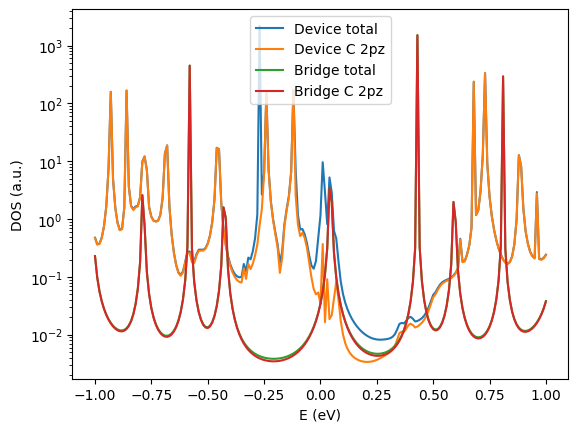

In [18]:
_, tdos_bridge = np.load("./unrelaxed/output/lowdin/bridge/dft/Evdos_total.npy")
_, pz_dos_bridge = np.load("./unrelaxed/output/lowdin/bridge/dft/Evdos_pz.npy")

plt.plot(E, tdos_device, label="Device total")
plt.plot(E, pz_dos_device, label="Device C 2pz")
plt.plot(E, tdos_bridge, label="Bridge total")
plt.plot(E, pz_dos_bridge, label="Bridge C 2pz")
plt.xlabel("E (eV)")
plt.ylabel("DOS (a.u.)")
plt.yscale("log")
# plt.ylim(0,10)
plt.legend()
plt.show()


The DOS plots of the uncoupled AGNR (Bridge) shows that the states around the Fermi energy can be described by C 2 pz alone. We also observe a state that sits at 0.0 eV. We see the differences in the total DOS due to the coupling of the bridge with the leads, but the state around 0.0 eV persists and is broader. However, when considering only the C 2 pz orbitals in the coupled state, while it captures all the other states fairly well, it is unable to capture the state around 0.0 eV completely. Why is this the case?

### Uncoupled AGNR: Us vs Source 3

Source 3: "Simulating graphene-based  single-electron transistor: incoherent  current effects due to the presence of  electron–electron interaction,  Washington F dos Santos et al"

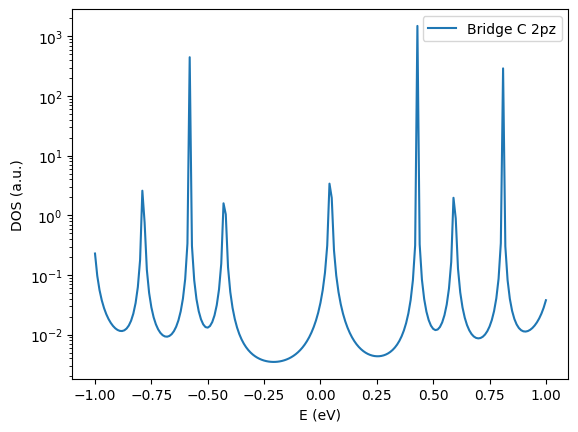
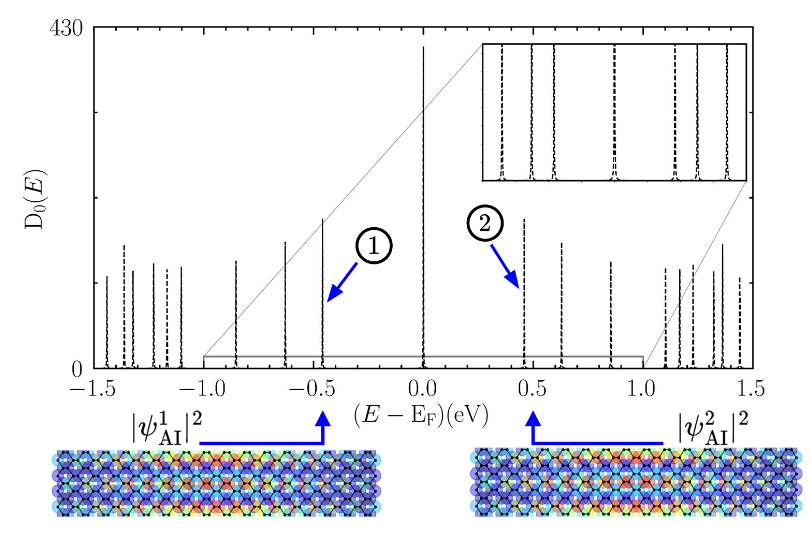

#### Similarities
- The existence of one peak at ~ 0.0 eV and ~ 3 peaks on either sides in the +- 1 eV energy window

#### Differences 
- Position of the peaks.
- (Our case) lack of symmetry in the DOS about 0.0 eV
- In our case, the DOS isn't highest at ~ 0.0 eV 
